In [1]:
import cv2.aruco as aruco
import pickle
import time

In [2]:
# load matrix and distortion from file
cameraMatrix, dist = pickle.load(open("calibration.pkl", "rb"))

In [3]:
import cv2
import cv2.aruco as aruco
import numpy as np

# Define parameters for ArUco marker detection
aruco_dict_type = cv2.aruco.DICT_6X6_250 # Change dictionary type if needed
marker_length = 0.05  # Marker length in meters (adjust as needed)
aruco_dict = cv2.aruco.getPredefinedDictionary(aruco_dict_type)

marker_id = 42
marker_size = 500  # Size in pixels
marker_image = cv2.aruco.generateImageMarker(aruco_dict, marker_id, marker_size)

proj_marker_image = cv2.aruco.generateImageMarker(aruco_dict, 43, marker_size)


In [4]:
import cv2
import matplotlib.pyplot as plt

camera_index = 0
cap = cv2.VideoCapture(camera_index, cv2.CAP_DSHOW) # this is the magic!


In [5]:
import time
# add white border to marker image
cv2.destroyAllWindows()

border_size = 2

proj_marker_image = cv2.aruco.generateImageMarker(aruco_dict, 43, marker_size)

proj_marker_image = cv2.copyMakeBorder(proj_marker_image, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, value=(255, 255, 255))





                               
# cv2.imshow("a",proj_marker_image_black_bord)
# cv2.waitKey(1)
# time.sleep(1)
# cv2.destroyAllWindows()

In [6]:

# import required libraries
import cv2
import numpy as np
drawing = False

done = False
ix,iy = -1,-1

rect_corners = None

# define mouse callback function to draw circle
def draw_rectangle(event, x, y, flags, param):
   global ix, iy, drawing, img, done, rect_corners
   if event == cv2.EVENT_LBUTTONDOWN:
      drawing = True
      ix = x
      iy = y

   elif event == cv2.EVENT_LBUTTONUP:
      drawing = False
      cv2.rectangle(img, (ix, iy),(x, y),(0, 255, 255),-1)
      rect_corners = [(ix, iy), (x, y)]
      done = True





# Create a black image
img = np.zeros((1080,1920,3), np.uint8)

# Create a window and bind the function to window
cv2.namedWindow("Rectangle Window", cv2.WND_PROP_FULLSCREEN)

# Connect the mouse button to our callback function
cv2.setMouseCallback("Rectangle Window", draw_rectangle)

# display the window
while True:
   cv2.imshow("Rectangle Window", img)
   if cv2.waitKey(10) == 27:
    break
# if done:
#     time.sleep(5)
    
# cv2.destroyAllWindows()


img = img[:,:,-1]

non_zero_indices = np.nonzero(img)

a,b,c,d = non_zero_indices[0].min(), non_zero_indices[0].max(), non_zero_indices[1].min(), non_zero_indices[1].max()
width = d - c
height = b - a

to_place = cv2.resize(proj_marker_image, (width+1, height+1), interpolation=cv2.INTER_AREA)

img[img!=0] = to_place.flatten()

cv2.imshow("Rectangle Window", img)

cv2.waitKey(1)



-1

In [7]:
img_orig = img.copy()

In [8]:
orig_rect_corners = [(rect_corners[0][0], rect_corners[0][1]), (rect_corners[1][0], rect_corners[0][1]), (rect_corners[1][0], rect_corners[1][1]), (rect_corners[0][0], rect_corners[1][1])]

In [9]:
aruco_dict = aruco.getPredefinedDictionary(aruco_dict_type)
parameters = aruco.DetectorParameters()

# Detect ArUco markers
detector = aruco.ArucoDetector(aruco_dict, parameters)

In [10]:
def rotate_marker_corners(rvec, markersize, tvec = None):

    mhalf = markersize / 2.0
    # convert rot vector to rot matrix both do: markerworld -> cam-world
    mrv, jacobian = cv2.Rodrigues(rvec)

    #in markerworld the corners are all in the xy-plane so z is zero at first
    X = mhalf * mrv[:,0] #rotate the x = mhalf
    Y = mhalf * mrv[:,1] #rotate the y = mhalf
    minusX = X * (-1)
    minusY = Y * (-1)

    # calculate 4 corners of the marker in camworld. corners are enumerated clockwise
    markercorners = []
    markercorners.append(np.add(minusX, Y)) #was upper left in markerworld
    markercorners.append(np.add(X, Y)) #was upper right in markerworld
    markercorners.append(np.add( X, minusY)) #was lower right in markerworld
    markercorners.append(np.add(minusX, minusY)) #was lower left in markerworld
    # if tvec given, move all by tvec
    if tvec is not None:
        C = tvec #center of marker in camworld
        for i, mc in enumerate(markercorners):
            makercorners[i] = np.add(C,mc) #add tvec to each corner
    #print('Vec X, Y, C, dot(X,Y)', X,Y,C, np.dot(X,Y)) # just for debug
    markercorners = np.array(markercorners,dtype=np.float32) # type needed when used as input to cv2
    return markercorners, mrv


In [11]:
def my_estimatePoseSingleMarkers(corners, marker_size, mtx, distortion):
    '''
    This will estimate the rvec and tvec for each of the marker corners detected by:
       corners, ids, rejectedImgPoints = detector.detectMarkers(image)
    corners - is an array of detected corners for each detected marker in the image
    marker_size - is the size of the detected markers
    mtx - is the camera matrix
    distortion - is the camera distortion matrix
    RETURN list of rvecs, tvecs, and trash (so that it corresponds to the old estimatePoseSingleMarkers())
    '''
    marker_points = np.array([[-marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, -marker_size / 2, 0],
                              [-marker_size / 2, -marker_size / 2, 0]], dtype=np.float32)
    trash = []
    rvecs = []
    tvecs = []
    
    for c in corners:
        nada, R, t = cv2.solvePnP(marker_points, c, mtx, distortion, False, cv2.SOLVEPNP_IPPE_SQUARE)
        rvecs.append(R)
        tvecs.append(t)
        trash.append(nada)
    return rvecs, tvecs, trash



In [12]:
orig_proj_corners = np.array(orig_rect_corners) # np.array([[0, 0], [proj_marker_image.shape[1], 0], [proj_marker_image.shape[1], proj_marker_image.shape[0]], [0, proj_marker_image.shape[0]]], dtype=np.float32)
orig_aruco_corners = np.array([[0, 0], [marker_image.shape[1], 0], [marker_image.shape[1], marker_image.shape[0]], [0, marker_image.shape[0]]], dtype=np.float32)
orig_proj_striped_corners = np.array([[0, 0], [proj_marker_image.shape[1], 0], [proj_marker_image.shape[1], proj_marker_image.shape[0]], [0, proj_marker_image.shape[0]]], dtype=np.float32)

In [13]:
ids = []
while ids is None or 43 not in ids:
    for i in range(10):
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture image")
            break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners, ids, _ = detector.detectMarkers(gray)

print(ids)

corners_img_proj = corners[np.where(ids == 43)[0].item()]
corners_img_aruco = corners[np.where(ids == 42)[0].item()]

H_proj, _ = cv2.findHomography(orig_proj_corners, corners_img_proj)
H_aruco, _ = cv2.findHomography(orig_aruco_corners, corners_img_aruco)
H_proj_striped, _ = cv2.findHomography(orig_proj_striped_corners, corners_img_proj)

proj_rvecs, proj_tvecs, _ = my_estimatePoseSingleMarkers(corners_img_proj, marker_length, cameraMatrix, dist)
aruco_rvecs, aruco_tvecs, _ = my_estimatePoseSingleMarkers(corners_img_aruco, marker_length, cameraMatrix, dist)

orig_proj_vecs = [proj_rvecs[0], proj_tvecs[0]]
orig_aruco_vecs = [aruco_rvecs[0], aruco_tvecs[0]]

orig_Hs = np.array([H_proj, H_aruco, H_proj_striped])

orig_corners = np.array([orig_proj_corners, orig_aruco_corners])

orig_img_corners = np.array([corners_img_proj, corners_img_aruco])

orig_frame = frame.copy()


[[43]
 [42]]


In [14]:
orig_mapping_H = orig_Hs[0] @ np.linalg.inv(orig_Hs[1])

In [15]:
orig_mapping_H @ orig_Hs[1]

array([[ 2.02537695e-01,  3.79373240e-02,  1.87982451e+02],
       [ 3.50724204e-03,  2.16466541e-01, -9.27149676e-01],
       [-2.95098194e-06,  1.42646814e-04,  1.00000000e+00]])

In [16]:
orig_Hs[0]

array([[ 2.02537695e-01,  3.79373240e-02,  1.87982451e+02],
       [ 3.50724204e-03,  2.16466541e-01, -9.27149676e-01],
       [-2.95098194e-06,  1.42646814e-04,  1.00000000e+00]])

In [17]:
orig_aruco_corners
# apply homography on orig_aruco_corners
cv2.perspectiveTransform(corners[np.where(ids == 42)[0].item()][0].reshape(-1, 1, 2), np.linalg.inv(H_aruco) ).reshape(-1, 2).astype(np.float16)

array([[  0.,   0.],
       [500.,   0.],
       [500., 500.],
       [ -0., 500.]], dtype=float16)

In [18]:
import IPython

In [ ]:
inv_orig_aruco = np.linalg.inv(orig_Hs[1])
cap_frames =[]
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture image")
        break
    cap_frames.append(frame.copy())

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners, ids, _ = detector.detectMarkers(gray)
    # print(ids)

    if ids is not None and 42 in ids:
        # H_proj, _ = cv2.findHomography(orig_proj_corners, corners[np.where(ids == 43)[0].item()][0])
        H_aruco, _ = cv2.findHomography(orig_aruco_corners, corners[np.where(ids == 42)[0].item()][0])

        # cur_corners_img_proj = corners[np.where(ids == 43)[0].item()]
        cur_corners_img_aruco = corners[np.where(ids == 42)[0].item()]


        aruco_rvecs, aruco_tvecs, _ = my_estimatePoseSingleMarkers(corners[np.where(ids == 42)[0].item()], marker_length, cameraMatrix, dist)


        # R_curr, _ = cv2.Rodrigues(aruco_rvecs[0])
        # R_orig, _ = cv2.Rodrigues(orig_aruco_vecs[0])

        # R_diff = R_orig @ R_curr.T
        # t_diff = orig_aruco_vecs[1] - (R_diff @ aruco_tvecs[0])

        # Draw the detected markers and their axes 
        frame = aruco.drawDetectedMarkers(frame, corners, ids)
        frame = cv2.drawFrameAxes(frame, cameraMatrix, dist, aruco_rvecs[0], aruco_tvecs[0], 0.1)  # Draw axis for the detected marker

        # cv2.putText(frame, f"R_diff: {R_diff}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        # cv2.putText(frame, f"t_diff: {t_diff}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0 , 255), 1)

        cv2.imshow('frame', frame)

        key = cv2.waitKey(1)

        if key == ord('q'):
            break

        # print("R_diff: \n", R_diff)
        # print("t_diff: \n", t_diff)


        # new_corn = cv2.perspectiveTransform(corners[np.where(ids == 42)[0].item()][0].reshape(-1, 1, 2), np.linalg.inv(orig_Hs[1]) ).reshape(-1, 2).astype(np.float16)

        # print("new corners: \n")

        # print(new_corn)

        diff_H =    H_aruco @ inv_orig_aruco

        H_aruco_disp, _ = cv2.findHomography(orig_img_corners[1], corners[np.where(ids == 42)[0].item()][0])

        
        M = find_M(orig_frame,frame)

    

        # corners_img_proj_warped = cv2.perspectiveTransform(corners_img_proj.reshape(-1, 1, 2), M).reshape(-1, 2).astype(np.float16)


        proj_marker_image_rgb = np.expand_dims(img_orig, axis=-1)
        proj_marker_image_rgb = np.repeat(proj_marker_image_rgb, 3, axis=-1)

        warped_proj_orig = cv2.warpPerspective(proj_marker_image_rgb, orig_Hs[0] , (frame.shape[1], frame.shape[0])) 
        warped_proj_orig_mask = cv2.warpPerspective(proj_marker_image_rgb*0+1, orig_Hs[0] , (frame.shape[1], frame.shape[0])) 

        ##############################################################################
        proj_striped_marker_image_rgb = np.expand_dims(proj_marker_image, axis=-1)
        proj_striped_marker_image_rgb = np.repeat(proj_striped_marker_image_rgb, 3, axis=-1)

        warped_proj_orig_striped = cv2.warpPerspective(proj_striped_marker_image_rgb, orig_Hs[2] , (frame.shape[1], frame.shape[0]))
        warped_proj_orig_striped_mask = cv2.warpPerspective(proj_striped_marker_image_rgb*0+1, orig_Hs[2] , (frame.shape[1], frame.shape[0]))

        sum_tensor = (1-warped_proj_orig_striped_mask) * frame + warped_proj_orig_striped
        cv2.imshow("sum_tensor_orig", sum_tensor)

        M_new = M.copy()
        M_new[:2,:2] = np.linalg.inv(M[:2,:2])
        
        warped_proj = cv2.warpPerspective(warped_proj_orig, M_new  , (frame.shape[1], frame.shape[0]))
        warped_proj_mask = cv2.warpPerspective(warped_proj_orig_mask, M_new  , (frame.shape[1], frame.shape[0]))

        warped_proj_striped = cv2.warpPerspective(warped_proj_orig_striped, M  , (frame.shape[1], frame.shape[0]))
        warped_proj_striped_mask = cv2.warpPerspective(warped_proj_orig_striped_mask, M  , (frame.shape[1], frame.shape[0]))


        sum_tensor = (1-warped_proj_striped_mask) * frame + warped_proj_striped

        cv2.imshow("sum_tensor", sum_tensor)
        key = cv2.waitKey(1)

        if key == ord('q'):
            break
        
        
        # time.sleep(0.5)

        # clear the console
        # IPython.display.clear_output(wait=True)

        warped_proj_inv = cv2.warpPerspective(warped_proj, np.linalg.inv(orig_Hs[0]), (img.shape[1], img.shape[0]))

        cv2.imshow("Rectangle Window", warped_proj_inv)

        key = cv2.waitKey(1)
        if key == ord('q'):
            break

        R_curr, _ = cv2.Rodrigues(aruco_rvecs[0])
        R_orig, _ = cv2.Rodrigues(orig_aruco_vecs[0])

        R_diff = R_orig @ np.linalg.inv(R_curr)  

        t_diff = orig_aruco_vecs[1] - (R_diff @ aruco_tvecs[0])


        r_diff = cv2.Rodrigues(R_diff)[0]

        print("t_diff: \n", t_diff)

        print("R_diff: \n", R_diff)

        print("r_diff: \n", r_diff)


        IPython.display.clear_output(wait=True)



t_diff: 
 [[-0.18815518]
 [-0.10923106]
 [ 0.04959267]]
R_diff: 
 [[ 0.98143377 -0.0394198   0.18770677]
 [ 0.02033391  0.99452104  0.10253992]
 [-0.19072044 -0.09681933  0.97685809]]


array([[-0.10047103],
       [ 0.19071586],
       [ 0.03011406]])

In [64]:
M_new = M.copy()
M_new[:2,:2] = np.linalg.inv(M[:2,:2])

In [63]:
np.linalg.inv(M[:2,:2])

array([[ 1.00348749e+00, -1.79602040e-02],
       [-7.96639024e-04,  9.98411088e-01]])

In [39]:
M_new

array([[ 0.91817796, -0.04742376,  6.6862507 ],
       [-0.00694456,  0.9192998 , -6.7140985 ],
       [ 0.        ,  0.        ,  1.        ]], dtype=float32)

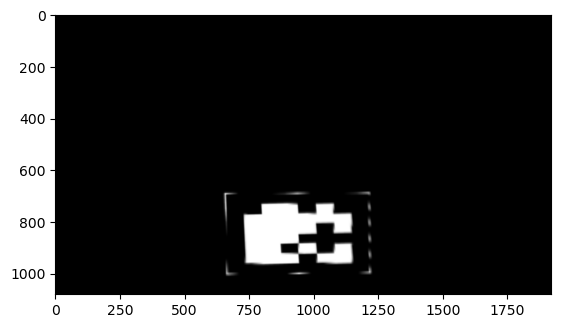

In [32]:
plt.imshow(warped_proj_inv)

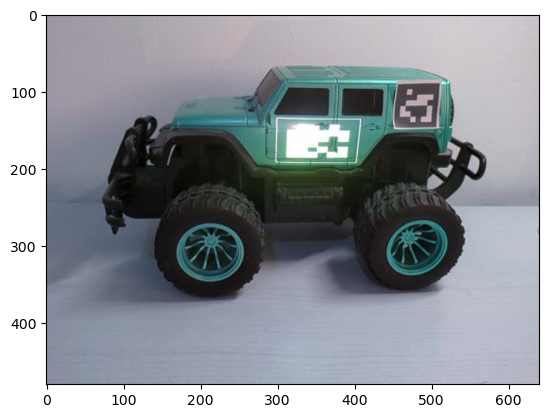

In [273]:
plt.imshow(orig_frame)

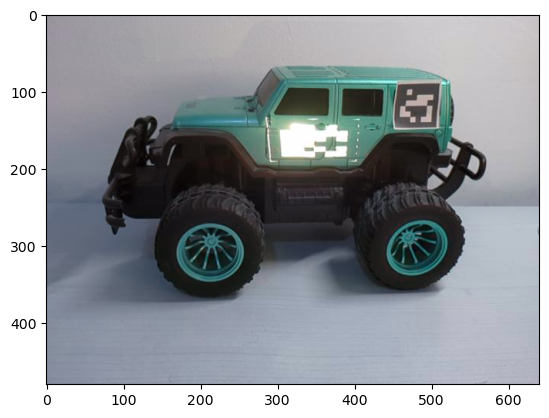

In [275]:
plt.imshow(cap_frames[0])

In [20]:
sift = cv2.SIFT_create()

def find_M(img1, img2):

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)    

    return M    

In [285]:
if len(good)>1:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
 
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
 
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
 
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
 
else:
    print( "Not enough matches are found - {}/{}".format(len(good), 1) )
    matchesMask = None

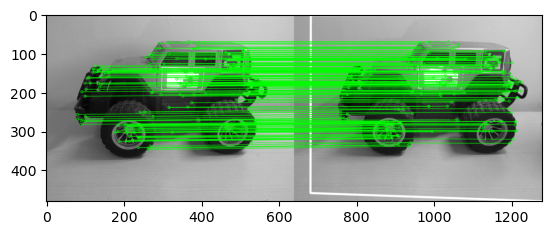

(<matplotlib.image.AxesImage at 0x24c81cb7f40>, None)

In [287]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
 
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
 
plt.imshow(img3, 'gray'),plt.show()

In [121]:
tvec_diff = orig_aruco_vecs[1] - aruco_tvecs

In [ ]:
# apply translation to corners
corners_img_proj = corners[np.where(ids == 43)[0].item()]



In [129]:
orig_aruco_corners_zerod

array([[  0.,   0.,   0.],
       [500.,   0.,   0.],
       [500., 500.,   0.],
       [  0., 500.,   0.]])

In [148]:
orig_aruco_corners_zerod = np.hstack((orig_aruco_corners, np.zeros((orig_aruco_corners.shape[0], 1))))

In [47]:

R_curr, _ = cv2.Rodrigues(aruco_rvecs[0])
R_orig, _ = cv2.Rodrigues(orig_aruco_vecs[0])

R_diff = R_orig @ np.linalg.inv(R_curr)  

r_diff, _ = cv2.Rodrigues(R_diff)

# t_diff = orig_aruco_vecs[1] - (R_diff @ aruco_tvecs[0])
t_diff = orig_aruco_vecs[1] - aruco_tvecs[0]

In [48]:
R_diff

array([[ 9.89826174e-01, -7.09221126e-02,  1.23345855e-01],
       [-5.09658877e-04,  8.65138726e-01,  5.01532377e-01],
       [-1.42281012e-01, -4.96492738e-01,  8.56300809e-01]])

In [220]:
orig_aruco_vecs[0] - aruco_rvecs

array([[[ 0.71651215],
        [-0.49051697],
        [-0.42964893]]])

In [251]:
r_diff

array([[-0.13456126],
       [ 0.09103257],
       [ 0.07222485]])

In [172]:
orig_proj_vecs

[array([[-2.02030637],
        [ 0.00883464],
        [ 0.05261797]]),
 array([[ 0.03442018],
        [-0.03547797],
        [ 0.5050318 ]])]

In [171]:
orig_aruco_vecs

[array([[-1.9729876 ],
        [ 1.94529986],
        [ 0.17475223]]),
 array([[ 0.18469799],
        [-0.10982681],
        [ 0.98993143]])]

In [156]:
orig_img_corners[1]

array([[[498., 147.],
        [502.,  93.],
        [556.,  93.],
        [549., 148.]]], dtype=float32)

In [163]:
orig_img_corners[1].mean(1)

array([[526.25, 120.25]], dtype=float32)

In [189]:
cv2.projectPoints(orig_aruco_vecs[1], aruco_rvecs[0]*0, aruco_tvecs[0]*0, cameraMatrix, dist)[0]

array([[[526.59258112, 120.3331102 ]]])

In [253]:
cv2.projectPoints(orig_proj_vecs[1], r_diff, t_diff, cameraMatrix, dist)[0]

array([[[641.45965074, 333.04238   ]]])

In [252]:
cv2.projectPoints(orig_aruco_vecs[1], r_diff, t_diff, cameraMatrix, dist)[0]

array([[[655.45378787, 285.03740488]]])

In [197]:
cv2.projectPoints(orig_aruco_vecs[1], aruco_rvecs[0]*0, t_diff, cameraMatrix, dist)[0]

array([[[508.41156016, 120.83445556]]])

In [79]:
corners[np.where(ids == 42)[0].item()][0]

array([[517., 148.],
       [522.,  93.],
       [575.,  92.],
       [569., 148.]], dtype=float32)

In [111]:
# add coloum of zeros to orig_corners[1]
orig_corn_zerod = np.hstack((orig_corners[1], np.zeros((orig_corners[1].shape[0], 1), dtype=np.float32)))

In [112]:
pts_3d_transformed = (R_diff @ orig_corn_zerod.T).T + t_diff.T

In [116]:
rvec_zero = np.zeros((3,1))  # no rotation (because we already applied R_rel)
tvec_zero = np.zeros((3,1))  # no translation (already applied)

imgpts, _ = cv2.projectPoints(pts_3d_transformed, rvec_zero, tvec_zero, cameraMatrix, dist)


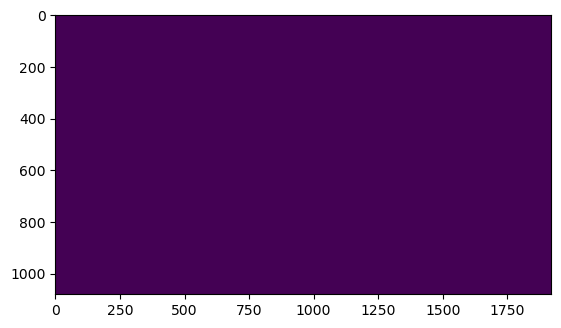

In [65]:
plt.imshow(cv2.warpPerspective(img_orig, np.linalg.inv(orig_Hs[0]), (img.shape[1], img.shape[0])))

In [ ]:
orig_mapping_H @ H_aruco_disp 

In [ ]:
plt.imshow(proj_marker_image_rgb)

In [ ]:
orig_mapping_H

In [ ]:
plt.imshow(cv2.warpPerspective(warped_proj_orig, H_aruco_disp, (frame.shape[1], frame.shape[0])))

In [ ]:
plt.imshow(warped_proj)

In [ ]:
plt.imshow(warped_proj_orig)

In [ ]:
diff_H

In [ ]:
H_aruco_disp

In [ ]:
plt.imshow(img)

In [ ]:
cv2.destroyAllWindows()

In [ ]:
warped_proj_inv = cv2.warpPerspective(warped_proj, np.linalg.inv(orig_Hs[0]), (img.shape[1], img.shape[0]))

In [ ]:
cv2.imshow("a", proj_marker_image_black_bord)

cv2.waitKey(1)





In [ ]:
cv2.imshow("a", warped_proj_inv)

cv2.waitKey(1)





In [ ]:
cv2.destroyAllWindows()

In [ ]:
plt.imshow(proj_marker_image)

In [ ]:
warped_proj_orig_mask.shape

In [ ]:
plt.imshow(warped_proj_orig)

In [ ]:
plt.imshow(cv2.warpPerspective(warped_proj_orig*0+1, diff_H, (frame.shape[1], frame.shape[0])))

In [ ]:
    frame = aruco.drawDetectedMarkers(frame, corners, ids)


    dst_pts = corners[0][0]
    H, _ = cv2.findHomography(orig_aruco_corners, dst_pts, cv2.RANSAC)
    warp_img = cv2.warpPerspective(proj_marker_image, H, (frame.shape[1], frame.shape[0]))
    warp_mask = cv2.warpPerspective(proj_marker_image*0+1, H, (frame.shape[1], frame.shape[0]))
    sum_tensor = frame * (1 - warp_mask) + warp_img * warp_mask

In [ ]:
# apply t_diff on proj_marker_image


In [ ]:
corn_diff= new_corn - orig_aruco_corners 

In [ ]:
corn_diff

In [ ]:
orig_proj_corners

In [ ]:
ids

In [ ]:
R_diff

In [ ]:
aruco_tvecs

In [ ]:
diff_H =   H_aruco @ np.linalg.inv(orig_Hs[1])

In [ ]:
warped_proj_orig = cv2.warpPerspective(proj_marker_image, orig_Hs[0], (frame.shape[1], frame.shape[0]))


In [ ]:
plt.imshow(warped_proj_orig)

In [ ]:
warped_proj = cv2.warpPerspective(warped_proj_orig, diff_H, (frame.shape[1], frame.shape[0]))
# warped_proj_mask = cv2.warpPerspective(warped_proj_orig*0+0.001, diff_H, (frame.shape[1], frame.shape[0]))
warped_proj_mask = (warped_proj != 0).astype(np.uint8) 

warped_proj_mask = np.expand_dims(warped_proj_mask, axis=-1)

sum_tensor = (1-warped_proj_mask) * frame
plt.imshow(sum_tensor)

In [ ]:
frame * (1 - warped_proj_mask)

In [ ]:
plt.imshow(warped_proj)

In [ ]:
plt.imshow(warped_proj)

In [ ]:
plt.imshow(warped_proj)

In [ ]:
A = H_aruco @ np.linalg.inv(orig_Hs[1])

In [ ]:
np.linalg.inv(orig_Hs[1]) @ H_aruco 

In [ ]:
A @ orig_Hs[0]

In [ ]:
plt.imshow(frame)

In [ ]:
warped_proj = cv2.warpPerspective(proj_marker_image, A @ orig_Hs[0], (frame.shape[1], frame.shape[0]))
warped_proj_mask = cv2.warpPerspective(np.ones(proj_marker_image.shape, dtype=np.uint8), A @ orig_Hs[0], (frame.shape[1], frame.shape[0]))

In [ ]:
wrapped_proj_rgb.shape

In [ ]:
wrapped_proj_rgb = cv2.cvtColor(warped_proj, cv2.COLOR_GRAY2RGB)

wrapped_proj_mask_rgb = cv2.cvtColor(warped_proj_mask, cv2.COLOR_GRAY2RGB)


plt.imshow(wrapped_proj_rgb+frame*(1-wrapped_proj_mask_rgb))
plt.show()

In [ ]:
m = cv2.warpPerspective(proj_marker_image,  A @ orig_Hs[0], (frame.shape[1], frame.shape[0]))

In [ ]:
plt.imshow(m)

In [ ]:
marker_image_bord = cv2.copyMakeBorder(warped_proj, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, value=(255, 255, 255))
cv2.imshow("a",cv2.resize(marker_image_bord,(600,300)))
cv2.waitKey(1)
time.sleep(10)